In [2]:
from scipy.interpolate import interp1d
import numpy as np
import random
import matplotlib.pyplot as plt
import math
#for speed we'll use .5 as our initial guess of opponent's price, rather than a fully random policy
p_j=.5

In [3]:
#calculates the payoff of any state by computing flow plus the value of the future state given some p_j
def calculate_payoff(q_i, p_i, p_j_values, beta, future_state_values, eta):
    # Flow utility
    flow_utility_i = p_i * q_i

    # Calculate the weight using the specified expression
    weight = q_i * (1 - eta * p_i) / (q_i * (1 - eta * p_i) + (1 - q_i) * (1 - eta * p_j_values))

    # Create a linear interpolation function
    interp_function = interp1d(np.linspace(0, 1, len(future_state_values)), future_state_values, kind='linear', fill_value="extrapolate")

    # Perform linear interpolation
    future_state = interp_function(weight)

    # Print information for debugging
    #print("Flow Utility for Firm i:", flow_utility_i)
    #print("Weight:", weight)
    #print("Future State:", future_state)

    # Payoff function with the value of the future state
    payoff_i = flow_utility_i + beta * future_state

    return payoff_i


In [4]:
#creates a matrix of payoffs, where the rows correspond to weights .1, ..., .9 and the columns prices 0, .., .9, 1
def generate_payoff_matrix(q_values, p_values, beta, eta, t, p_j_values,future_state_values):
    # Initialize the payoff matrix for firm i
    payoff_matrix_i = np.zeros((len(q_values), len(p_values)))

    # Calculate payoff for each combination of q_i and p_i
    for i, q_i in enumerate(q_values):
        for j, p_i in enumerate(p_values):
            # Calculate payoff for firm i
            payoff_matrix_i[i, j] = calculate_payoff(q_values[i],p_values[j],p_j,beta,future_state_values,eta)
            #run the line below to use an array for p_j values instead of a constant (slower but can get more equilibria)
            #payoff_matrix_i[i, j] = calculate_payoff(q_values[i],p_values[j],p_j_values[i],beta,future_state_values,eta)
    return payoff_matrix_i


In [5]:
#Picks the optimal price by selecting the row where payoff is highest (column of max value in each row)
def find_optimal_prices(payoff_matrix, price_values):
    # Get the number of weights and prices
    num_weights, num_prices = payoff_matrix.shape

    # Initialize an array to store optimal prices for each weight
    optimal_prices = np.zeros(num_weights)

    # Find the index of the column (price) that maximizes the payoff for each weight
    optimal_price_indices = np.argmax(payoff_matrix, axis=1)

    # Map the index to the actual price value using the provided price values
    optimal_prices = price_values[optimal_price_indices]

    return optimal_prices


In [6]:
#computes the value of the state by taking the value at the optimal price for each weight (max value in each row)
def store_state_values(payoff_matrix, price_values=np.arange(0,1.1,1)):
    # Get the number of weights and prices
    num_weights, num_prices = payoff_matrix.shape

    # Initialize an array to store the state values for each weight
    state_values = np.zeros(num_weights)

    # Find the index of the column (price) that maximizes the payoff for each weight
    optimal_price_indices = np.argmax(payoff_matrix, axis=1)

    # Map the index to the actual price value using the provided price values
    optimal_prices = price_values[optimal_price_indices]

    # Store the value of the payoff matrix at each weight and optimal price
    for i in range(num_weights):
        state_values[i] = payoff_matrix[i, optimal_price_indices[i]]

    return state_values


In [7]:
#Starting with a guess for p_j, computes p_i from payoff matrix, uses this to recompute p_j
#iterates to convergence
def find_equilibrium_prices(q_values, p_values, beta, eta, t, future_state_values, initial_p_j_values, max_iterations=100, tolerance=1e-6):
    p_j_t = initial_p_j_values.copy()

    for iteration in range(max_iterations):
        # Calculate the payoff matrix for firm i using the current guess for p_j^t
        payoff_matrix_i_t = generate_payoff_matrix(q_values, p_values, beta, eta, t, p_j_t, future_state_values)

        # Find the optimal prices for firm i
        p_i_t = find_optimal_prices(payoff_matrix_i_t, p_values)

        # Calculate the payoff matrix for firm j using the updated p_i^t as prices
        payoff_matrix_j_t = generate_payoff_matrix(q_values, p_values, beta, eta, t, p_i_t, future_state_values)

        # Find the optimal prices for firm j
        p_j_t_updated = find_optimal_prices(payoff_matrix_j_t, p_values)

        # Check for convergence
        if np.allclose(p_j_t, p_j_t_updated, atol=tolerance):
            #print("Converged after", iteration + 1, "iterations.")
            return p_i_t, p_j_t_updated, payoff_matrix_i_t, payoff_matrix_j_t

        # Update p_j vector for the next iteration
        p_j_t = p_j_t_updated

    #print("Did not converge within the maximum number of iterations.")
    return p_i_t, p_j_t_updated, payoff_matrix_i_t, payoff_matrix_j_t


In [8]:
#initializes random p_j values
def initialize_p_j_values():
    return np.random.uniform(0, 1, 99)


In [9]:
#puts everything together: Starting at round T, computes optimal prices at each weight, stores the value (round T+1 values are 0)
#uses the stored value to compute the payoff in T-1, iterating for price until convergence, then storing price vector, state value vector
#does this to round 0, outputs a vector of prices for each firm for each round, and a vector of values, the first corresponds to weight .1, second to .2, etc.
def run_simulation_rounds(num_rounds, beta, eta):
    results = []

    # Set your initial future_state_values, beta, and eta
    q_values = np.arange(0.01, 1.0, 0.01)
    p_values = np.arange(0.0, 1.01, 0.01)

    # Loop from T-1 to round 1
    for t in range(num_rounds, 0, -1):
        # Update future_state_values
        future_state_values = np.zeros(9) if t == num_rounds else store_state_values(equilibrium_payoff_matrix_i, p_values)

        # Generate p_j_values based on some initial guess
        initial_p_j_values = initialize_p_j_values()

        # Call the find_equilibrium_prices function
        equilibrium_prices_i, equilibrium_prices_j, equilibrium_payoff_matrix_i, equilibrium_payoff_matrix_j = find_equilibrium_prices(
            q_values, p_values, beta, eta, t, future_state_values, initial_p_j_values, max_iterations=100, tolerance=1e-6
        )

        # Store state values for both firms
        state_values_i = store_state_values(equilibrium_payoff_matrix_i, p_values)
        state_values_j = store_state_values(equilibrium_payoff_matrix_j, p_values)

        # Append the results for this round
        results.append({
            "Round": t - 1,
            "Equilibrium Prices for Firm i": equilibrium_prices_i,
            "Equilibrium Prices for Firm j": equilibrium_prices_j,
            "State Values for Firm i": state_values_i,
            "State Values for Firm j": state_values_j
        })

    return results


[{'Round': 2,
  'Equilibrium Prices for Firm i': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'Equilibrium Prices for Firm j': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'State Values 

In [10]:
def subset_simulation_results(num_rounds, beta, eta, q_i_initial):
    # Run the simulation to get full results
    full_results = run_simulation_rounds(num_rounds, beta, eta)

    # Initialize dictionaries to store subset results
    subset_results = {
        'Round': [],
        'q_i_t': [],
        'q_j_t': [],
        'p_i_t': [],
        'p_j_t': [],
        'state_value_i_t': [],
        'state_value_j_t': []
    }

    q_i_t = q_i_initial

    for t in range(num_rounds):
        # Extract Round
        subset_results['Round'] = np.append(subset_results['Round'], full_results[num_rounds - t - 1]['Round'])

        # Extract values associated with the common key into an array
        # This is for q_i_t
        subset_results['q_i_t'] = np.append(subset_results['q_i_t'], q_i_t)
        subset_results['q_j_t'] = np.append(subset_results['q_j_t'], 1 - q_i_t)

        # This is for p_i_t
        subset_results['p_i_t'] = np.append(subset_results['p_i_t'], np.interp(q_i_t * 100 - 1, range(len(full_results[num_rounds - t - 1]['Equilibrium Prices for Firm i'])), full_results[num_rounds - t - 1]['Equilibrium Prices for Firm i']))
        subset_results['p_j_t'] = np.append(subset_results['p_j_t'], np.interp((1 - q_i_t) * 100 - 1, range(len(full_results[num_rounds - t - 1]['Equilibrium Prices for Firm j'])), full_results[num_rounds - t - 1]['Equilibrium Prices for Firm j']))

        subset_results['state_value_i_t'] = np.append(subset_results['state_value_i_t'], np.interp(q_i_t * 100 - 1, range(len(full_results[num_rounds - t - 1]['State Values for Firm i'])), full_results[num_rounds - t - 1]['State Values for Firm i']))
        subset_results['state_value_j_t'] = np.append(subset_results['state_value_j_t'], np.interp((1 - q_i_t) * 100 - 1, range(len(full_results[num_rounds - t - 1]['State Values for Firm j'])), full_results[num_rounds - t - 1]['State Values for Firm j']))

        p_i_t = subset_results['p_i_t'][-1]
        p_j_t = subset_results['p_j_t'][-1]

        q_i_t = q_i_t * (1 - eta * p_i_t) / (q_i_t * (1 - eta * p_i_t) + (1 - q_i_t) * (1 - eta * p_j_t))

    return subset_results



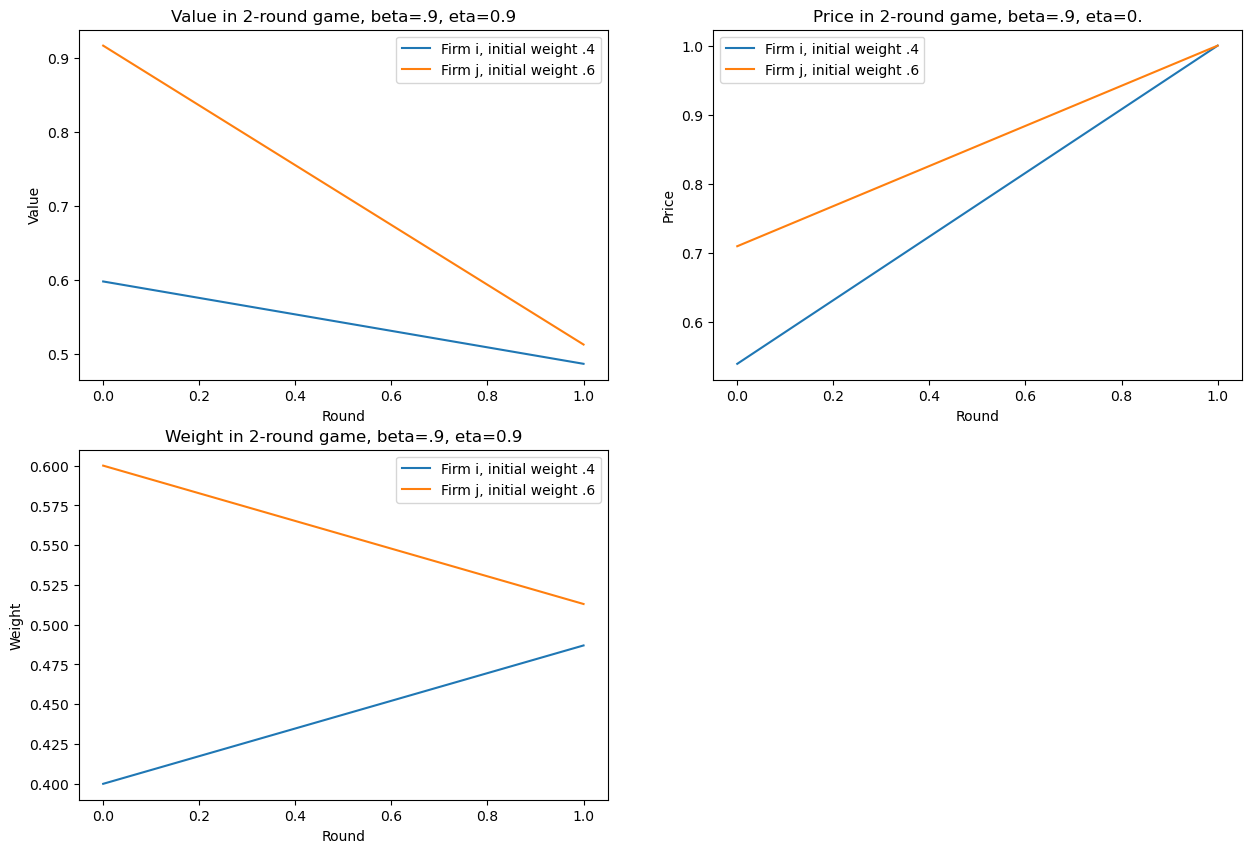

In [12]:
#graph of results for 2 rounds

num_rounds = 2
beta = 0.99
eta = 0.9
q_i_initial = 0.4

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .4')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .6')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 2-round game, beta=.9, eta=0.9')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .4')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .6')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 2-round game, beta=.9, eta=0.')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .4')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .6')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 2-round game, beta=.9, eta=0.9')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
plt.show()

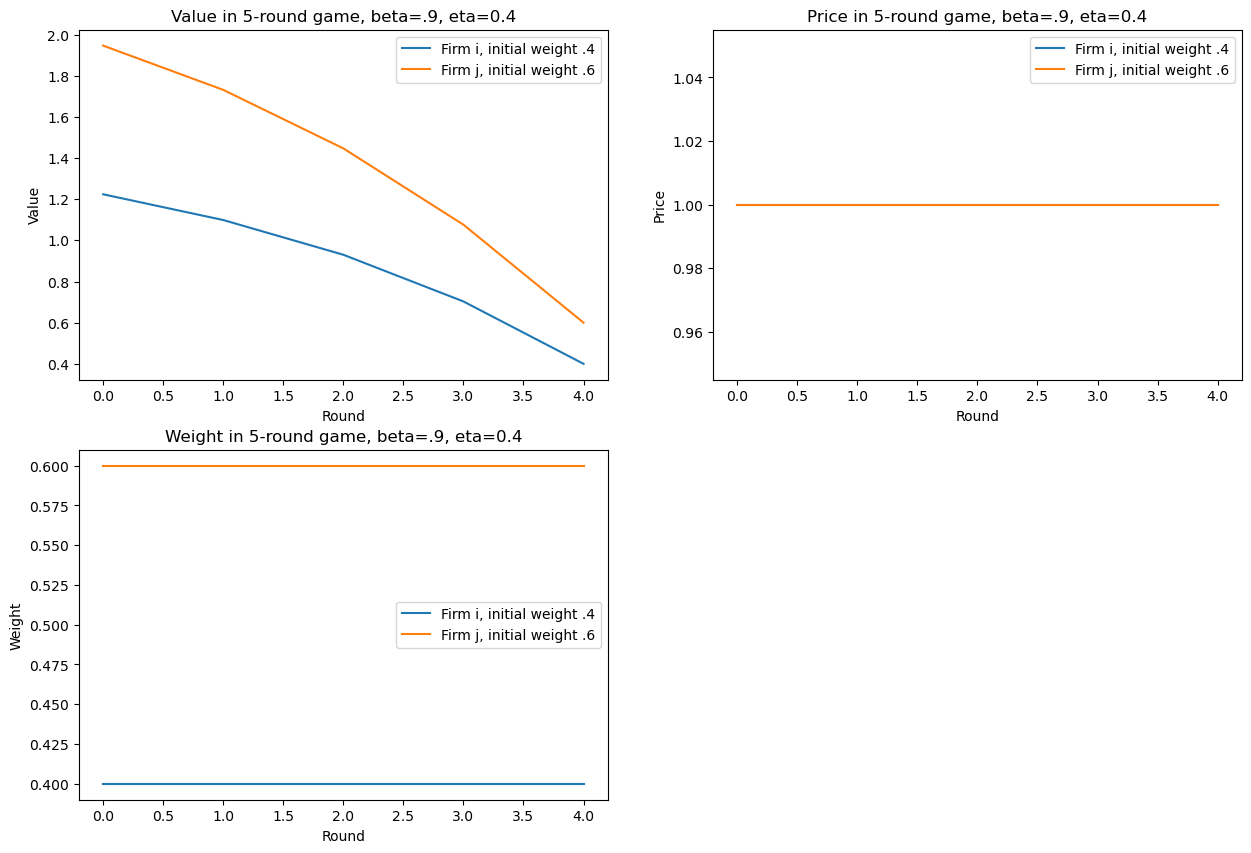

In [13]:
#graph of results for 5 rounds

num_rounds = 5
beta = 0.9
eta = 0.4
q_i_initial = 0.4

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .4')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .6')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 5-round game, beta=.9, eta=0.4')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .4')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .6')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 5-round game, beta=.9, eta=0.4')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .4')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .6')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 5-round game, beta=.9, eta=0.4')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
plt.show()

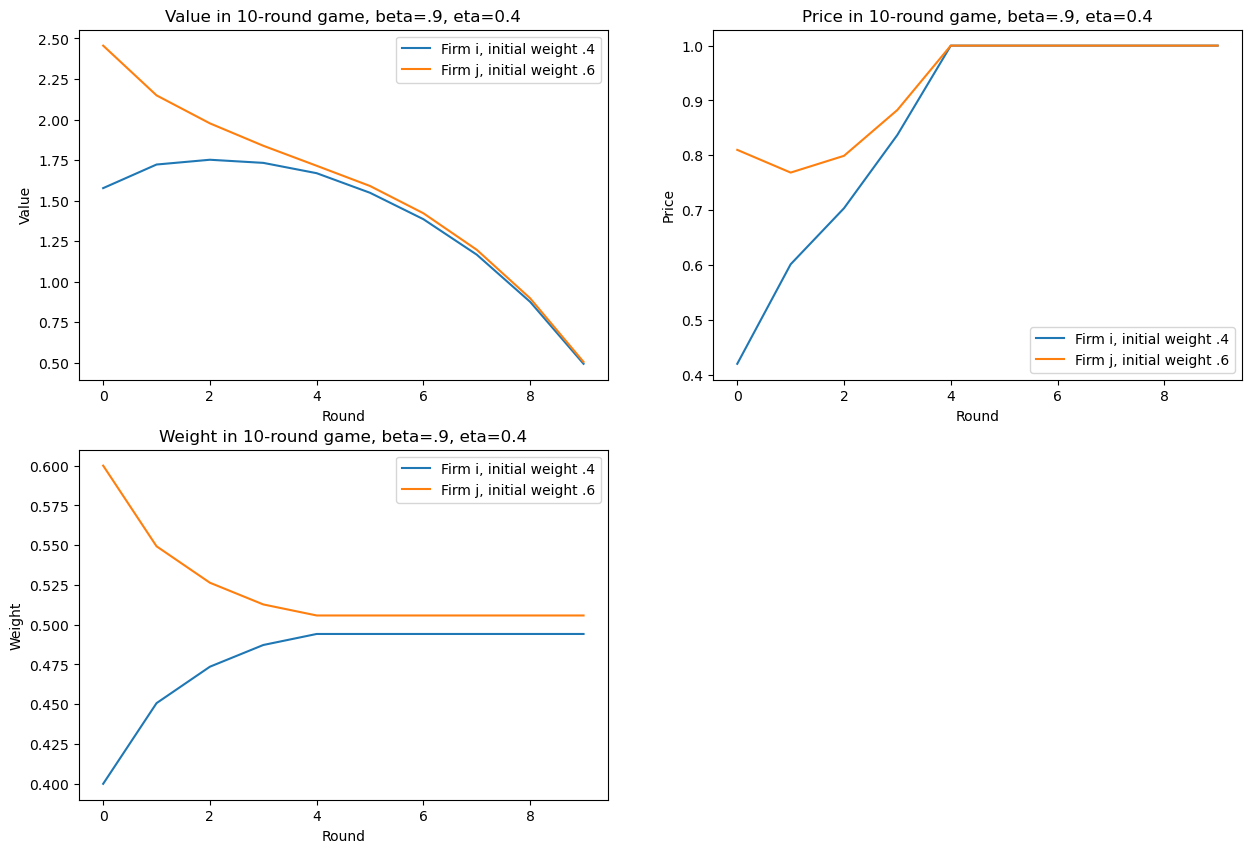

In [14]:
#graph of results for 10 rounds

num_rounds = 10
beta = 0.9
eta = 0.4
q_i_initial = 0.4

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .4')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .6')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 10-round game, beta=.9, eta=0.4')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .4')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .6')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 10-round game, beta=.9, eta=0.4')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .4')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .6')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 10-round game, beta=.9, eta=0.4')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
plt.show()


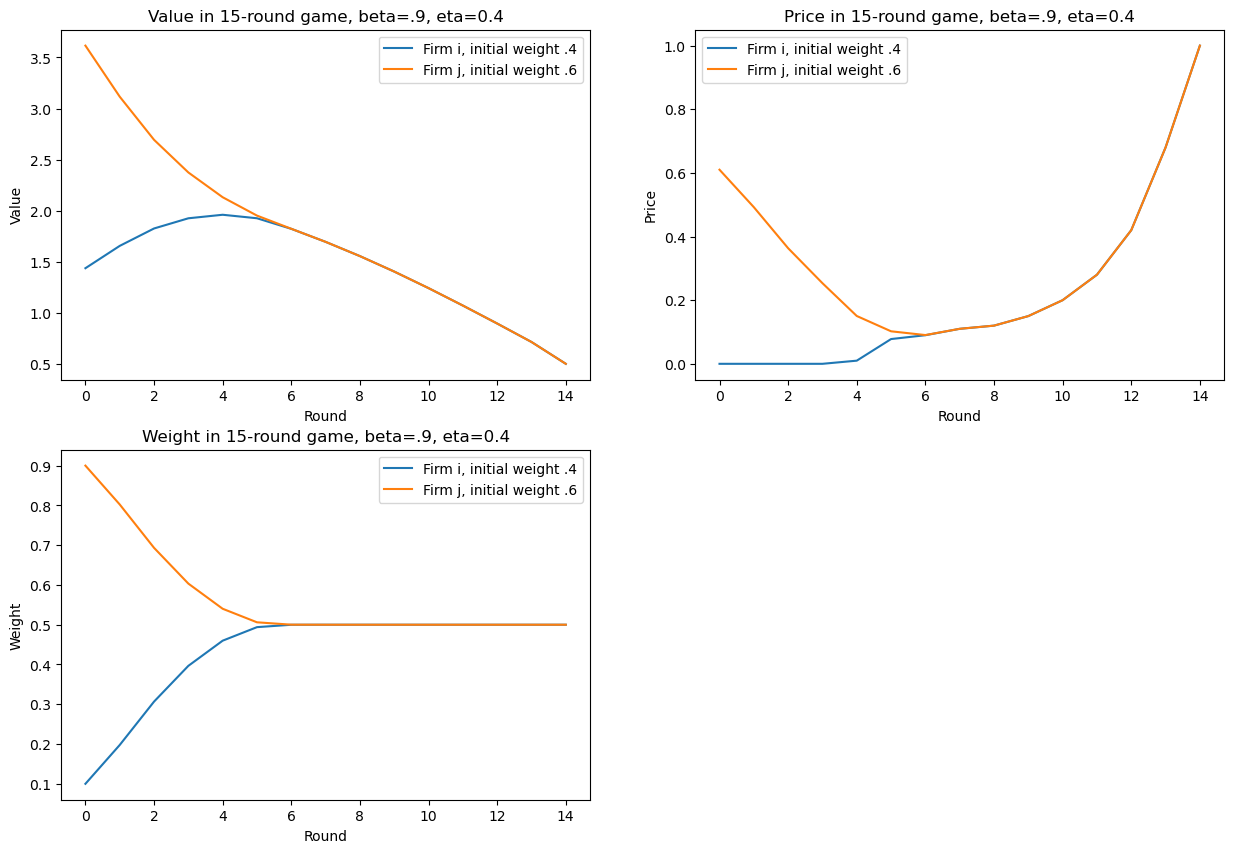

In [15]:
#graph of results for 15 rounds

num_rounds = 15
beta = 0.9
eta = .9
q_i_initial = 0.1

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .4')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .6')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 15-round game, beta=.9, eta=0.4')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .4')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .6')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 15-round game, beta=.9, eta=0.4')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .4')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .6')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 15-round game, beta=.9, eta=0.4')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
plt.show()

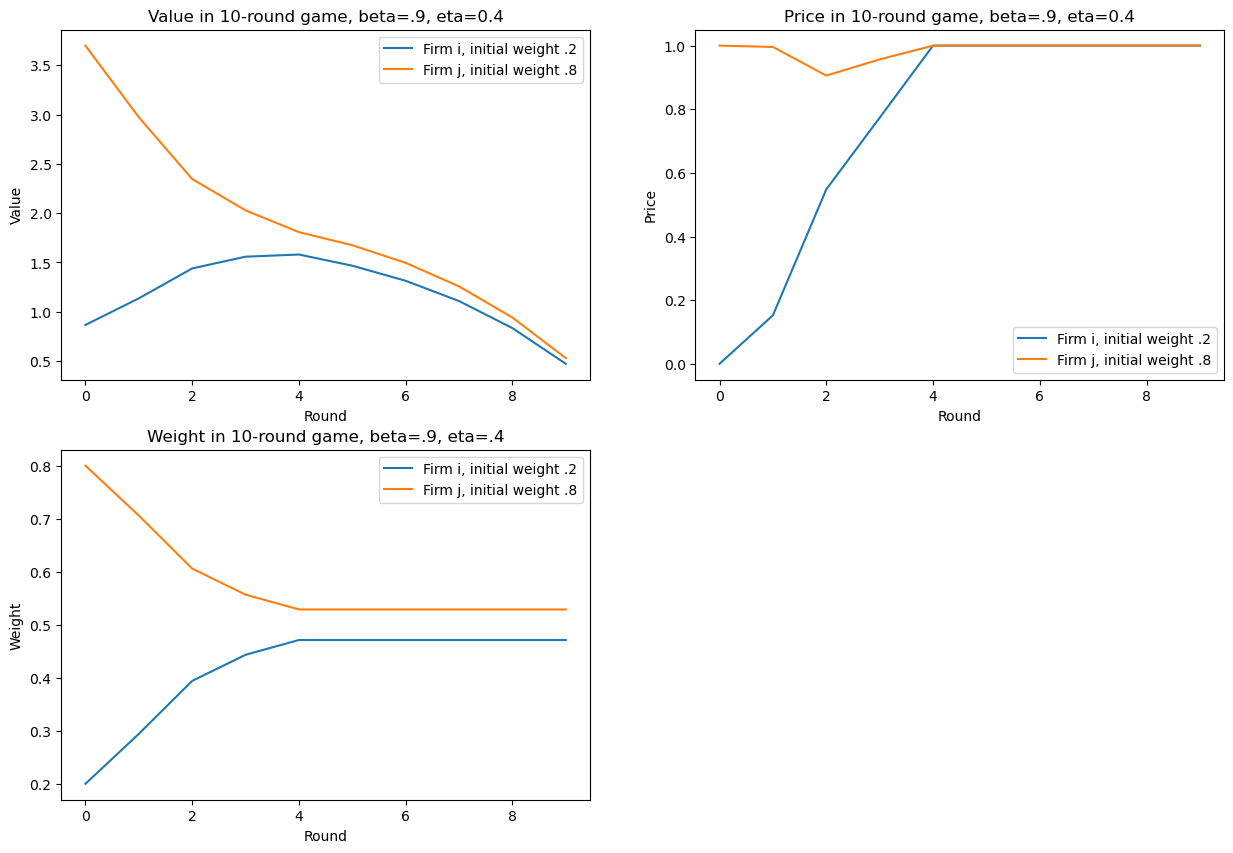

In [16]:
#graph of results for 10 rounds, even more uneven market share

num_rounds = 10
beta = 0.9
eta = 0.4
q_i_initial = 0.2

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .2')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .8')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 10-round game, beta=.9, eta=0.4')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .2')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .8')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 10-round game, beta=.9, eta=0.4')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .2')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .8')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 10-round game, beta=.9, eta=.4')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
plt.show()

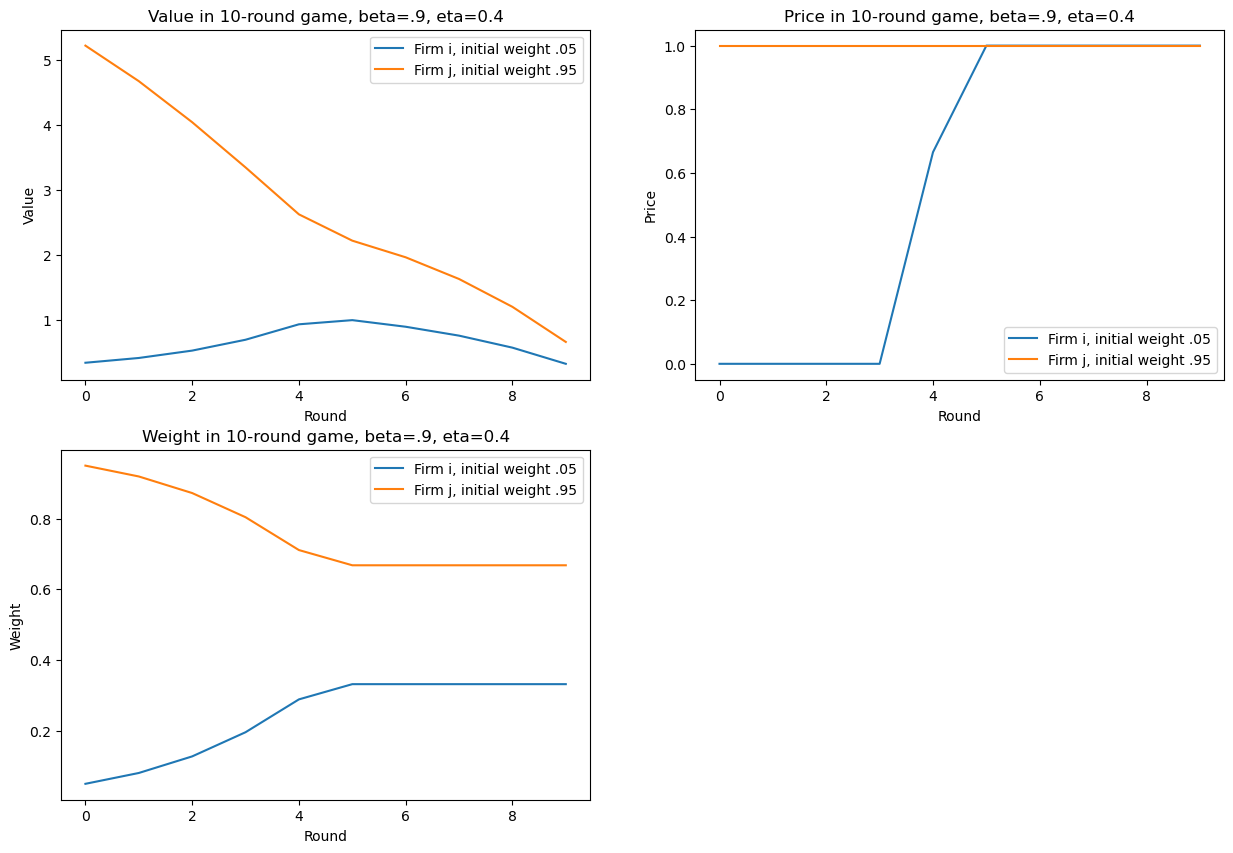

In [17]:
#graph of results for 10 rounds, even more uneven market share

num_rounds = 10
beta = 0.9
eta = 0.4
q_i_initial = 0.05

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .05')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .95')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 10-round game, beta=.9, eta=0.4')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .05')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .95')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 10-round game, beta=.9, eta=0.4')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .05')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .95')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 10-round game, beta=.9, eta=0.4')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
plt.savefig('rounds_10_mkt_share_05.png')

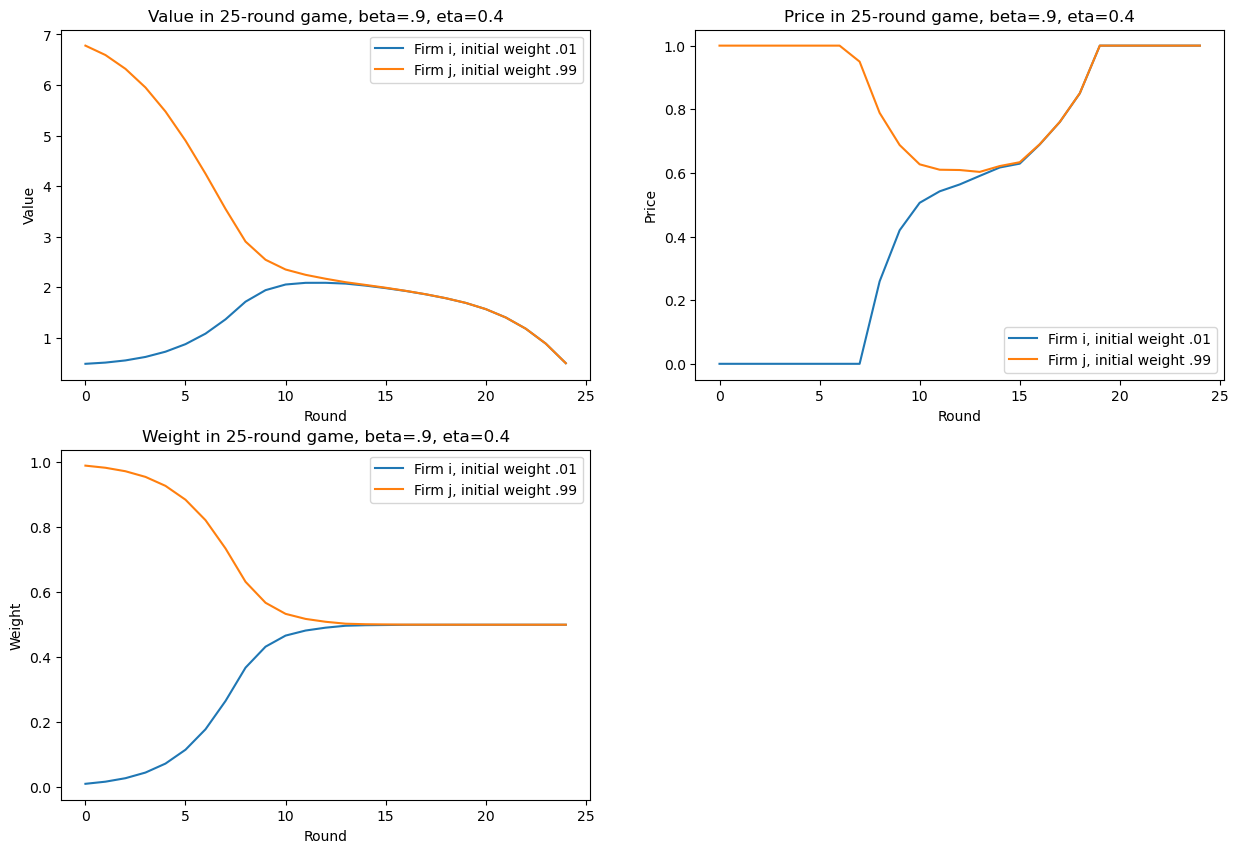

In [18]:
#graph of results for 10 rounds, even more uneven market share

num_rounds = 25
beta = 0.9
eta = 0.4
q_i_initial = 0.01

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .01')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .99')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 25-round game, beta=.9, eta=0.4')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .01')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .99')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 25-round game, beta=.9, eta=0.4')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .01')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .99')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 25-round game, beta=.9, eta=0.4')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
#plt.show()
plt.savefig('round_25_mkt_share_01.png')

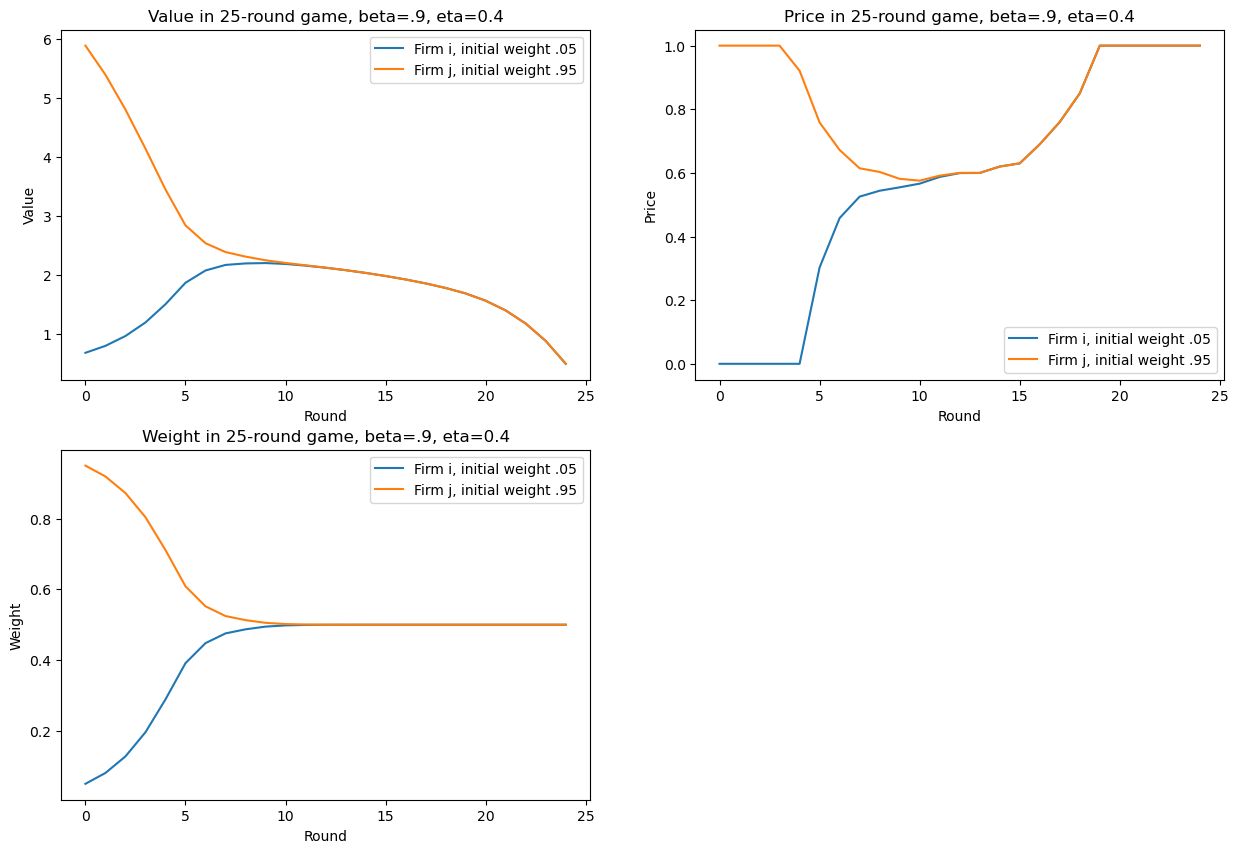

In [19]:
#graph of results for 25 rounds, 5% market share

num_rounds = 25
beta = 0.9
eta = 0.4
q_i_initial = 0.05

subset_results = subset_simulation_results(num_rounds, beta, eta, q_i_initial)
#set up plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the values
axs[0, 0].plot(subset_results['state_value_i_t'], label='Firm i, initial weight .05')
axs[0, 0].plot(subset_results['state_value_j_t'], label='Firm j, initial weight .95')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value in 25-round game, beta=.9, eta=0.4')
axs[0, 0].legend()

# Plotting the prices
axs[0, 1].plot(subset_results['p_i_t'], label='Firm i, initial weight .05')
axs[0, 1].plot(subset_results['p_j_t'], label='Firm j, initial weight .95')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Price in 25-round game, beta=.9, eta=0.4')
axs[0, 1].legend()

# Plotting the weights
axs[1, 0].plot(subset_results['q_i_t'], label='Firm i, initial weight .05')
axs[1, 0].plot(subset_results['q_j_t'], label='Firm j, initial weight .95')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('Weight')
axs[1, 0].set_title('Weight in 25-round game, beta=.9, eta=0.4')
axs[1, 0].legend()

# Hide the empty subplot
axs[1, 1].axis('off')

# Display the plot
plt.savefig('rounds_25_mkt_share_05.png')

In [21]:
num_rounds = 25
beta = 0.9
eta = 0.4
full_results=run_simulation_rounds(num_rounds, beta, eta)


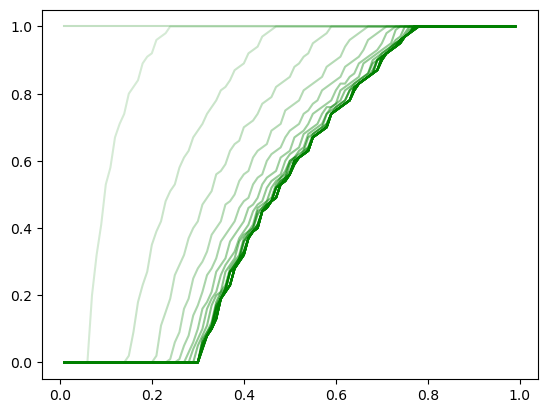

In [33]:
q_values=np.arange(.01,1,.01)
for i in range(24):
    plt.plot(q_values, full_results[24-i]['Equilibrium Prices for Firm i'], color='green', alpha=1-i/24)